## 04g - Vertex AI > Pipelines - Forecasting Tournament with Kubeflow (KFP) and BQML + AutoML + Prophet

Throughtout the `04` series, different focasting platforms have been demostrated: BigQuery ML ARIMA+, Vertex AI AutoML Forecasting, and Custom Jobs using Prophet.  This notebook, `04g`, looks at the question "How do I pick the best approach?".  A great way to do this is using Vertex AI Pipelines, a service that can run Kubeflow pipelines (KFP).  In this notebook a number of custom pipeline components will be constructed to run each of the platforms with multiple scenarios and do custom metric calculations to pick the best overall platform + scenario and the best platform/scenario for each individual time series (station for Citibike rentals).  This is a forecasting tournament!

It might be helpful to first review the previous notebooks in the `04` series to better understand each platform.

This notebook creates a BigQuery dataset to hold all the tables needed by the tournament.  The start of the notebook shows preparing the forecasting data source and storing it in the new dataset as a table named `source` and then creating a version with standardized columns names called `forecast_input`. The pipeline just needs the dataset name and `forecast_input` table to run all the methods.  The results are stored in tables within the same dataset.  Here is an overview of the data architecture:

<img src="architectures/overview/04g_Overview.png">

### Prerequisites:
-  04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Setup
- Custom Components (KFP)
    - Data Preparation
    - BigQuery ML ARIMA+
    - Vertex AI AutoML Forecasting
    - Vertex AI Training Custom Jobs For Forecasting with Prophet
    - Custom Container Build
        - Assemble Python File For Training
        - Choose a Base Image
        - Create the Dockerfile
        - Enable Artifact Registry API
        - Create A Repository
        - Configure Local Docker to Use GCLOUD CLI
        - Build The Custom Container (local to notebook)
        - Push The Container to Repository
    - Custom Metrics
    - Champion Selection: Overall Method
    - Champion Selection: By Series
- Vertex AI Pipeline
    - Pipeline (KFP) Definition
    - Compile Pipeline
    - Create Vertex AI Pipeline Job
    - Review Pipeline Job
- Results
    - Retrieve Source Data
    - Retrieve Fit Data
    - Retrieve Key Dates
    - Visual The Time Series With Forecast (Test Period)

### Resources:
-  

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04g_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04g_console.png">

---
## Setup

inputs:

In [1]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
NOTEBOOK = '04g'

# Used for Prophet Custom Forecasting Jobs
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/base-cpu'

# source table
BQ_SOURCE = 'bigquery-public-data.new_york.citibike_trips'

packages:

In [2]:
from google.cloud import bigquery
from google.cloud import aiplatform

from typing import NamedTuple
import kfp # used for dsl.pipeline
import kfp.v2.dsl as dsl # used for dsl.component, dsl.Output, dsl.Input, dsl.Artifact, dsl.Model, ...
from google_cloud_pipeline_components import aiplatform as gcc_aip

import matplotlib.pyplot as plt
from datetime import datetime
import json

clients:

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [4]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{NOTEBOOK}/models"
DIR = f"temp/{NOTEBOOK}"

BQ_DATASET = f"{NOTEBOOK}_tournament"

In [5]:
# Give service account roles/storage.objectAdmin permissions
# Console > IMA > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'715288179162-compute@developer.gserviceaccount.com'

environment:

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

GCP Configuaration Notes:

- If you are just trying this out as a tutorial then update the list of CW values in the pipeline definition to only have <= 5 values: [32, 16, 8, 2, 0]
- The AutoML component will need to run 7 concurrent jobs in this example.
- The default limit is 5 per: https://cloud.google.com/vertex-ai/docs/quotas#model_quotas
- I updated this to 10 with IAM > Quota using these instructions: https://cloud.google.com/docs/quota#requesting_higher_quota
- This will require waiting on the update

---
## Prepare BigQuery Dataset and Table

The Vertex AI Pipeline created below prepare a BigQuery table for forecasting with multiple methods and create output table for each method as well as tables covering all methods.  This section create the BigQuery Dataset and table of source data.

### Create BigQuery Dataset

In [7]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{BQ_DATASET}`
OPTIONS(
    location = 'US',
    labels = [('notebook','{NOTEBOOK}')]
)
"""
job = bigquery.query(query = query)
job.result()

### Create Source Table (BigQuery): forecast_source
A local set of data for the forecasting project - likely a subset of rows and columns

In [8]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_source` AS
SELECT
   start_station_name, starttime, tripduration, end_station_name, bikeid, usertype, gender
FROM `{BQ_SOURCE}`
WHERE start_station_name LIKE '%Central Park%'
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

3.507

### Create Prep Table (BigQuery): forecast_prep
Aggregate Data for Time Series
- [DATE_TRUNC](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#date_trunc)
- [TIME_TRUNC](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#time_trunc)

In [9]:
date_trunc = 'DAY' # DAY, WEEK, week(FRIDAY), ISOWEEK, MONTH, QUARTER, YEAR 

In [10]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_prep` AS
SELECT
   start_station_name as series,
   DATE_TRUNC(EXTRACT(DATE from starttime), {date_trunc}) as date,
   COUNT(*) AS target
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_source`
GROUP BY series, date
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.842

### Review Time Series: forecast_prep

In [11]:
query = f"""
SELECT series, sum(target) as total, min(date) as FromDate, max(date) as ToDate
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
GROUP BY series
ORDER BY series
"""
overview = bigquery.query(query = query).to_dataframe()
overview

,series,total,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


In [12]:
query = f"""
SELECT DISTINCT series, date
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
"""
dates = bigquery.query(query = query).to_dataframe()

Visualize each stations data time range:

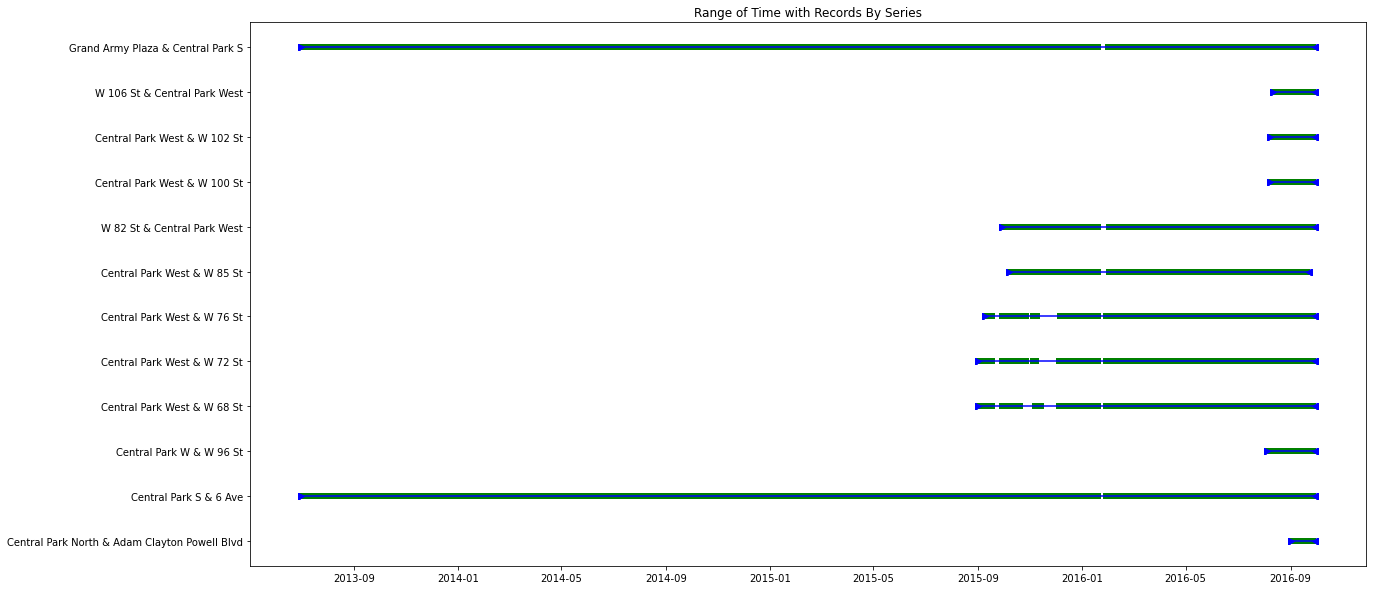

In [13]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['series'][i], overview['series'][i]]
    plt.plot(x, y, '.-b')
    plt.scatter(dates['date'], dates['series'], c='g', marker='|')
    plt.scatter(overview['FromDate'], overview['series'], c='b', marker='>')
    plt.scatter(overview['ToDate'], overview['series'], c='b', marker='<')
    plt.title('Range of Time with Records By Series')
plt.show()

### Create Input Table (BigQuery): forecast_input
Filter The Series, if needed

Rules Examples:
- data for at least 1 of last 14 days: RECENT_SERIES
- data for at least 28 days (gaps ok): FILTER_SERIES

In [14]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.forecast_input` AS
WITH
  ALL_SERIES AS (
    SELECT series, count(target) as counts, min(date) as FromDate, max(date) as ToDate
    FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
    GROUP BY series
  ),
  RECENT_SERIES AS (
    SELECT series, count(target) as recent_counts
    FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`
    WHERE date >= DATE_SUB((select max(date) from `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`), INTERVAL 14 DAY)
    GROUP BY series
  ),
  FILTER_SERIES AS (
    SELECT series
    FROM ALL_SERIES
    LEFT OUTER JOIN (SELECT * FROM RECENT_SERIES)
    USING (series)
    WHERE counts > 28 and recent_counts > 0
  ),
  DATELIST AS (
    SELECT DISTINCT series, date
    FROM (SELECT DISTINCT series FROM FILTER_SERIES) A
    CROSS JOIN (SELECT DATE_TRUNC(date, {date_trunc}) as date 
                FROM UNNEST(GENERATE_DATE_ARRAY(
                                (SELECT MIN(date) FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`),
                                (SELECT MAX(date) FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`),
                                INTERVAL 1 DAY
                            )
                        ) AS date
                ) B  
  ),
  EXPAND AS (
    SELECT *
    FROM DATELIST
    LEFT OUTER JOIN (SELECT * FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_prep`)
    USING (series, date)
    ORDER BY series, date
    )
SELECT *
FROM EXPAND
WHERE target is not NULL
ORDER BY series, date
"""
job = bigquery.query(query = query)
job.result()

### Review Time Series: forecast_input

In [15]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{BQ_DATASET}.forecast_input`
"""
rawSeries = bigquery.query(query = query).to_dataframe()

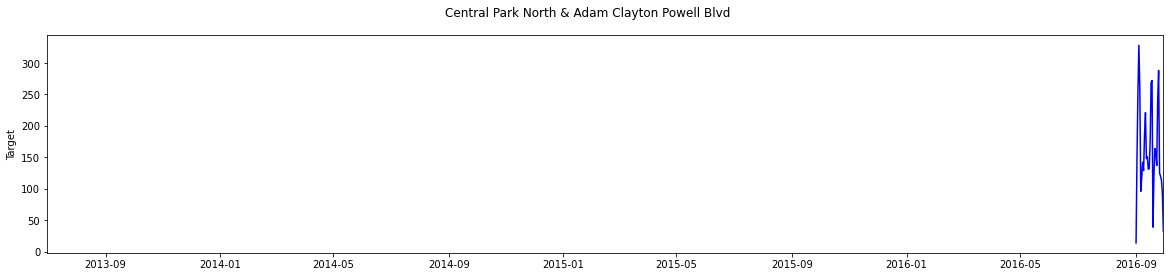

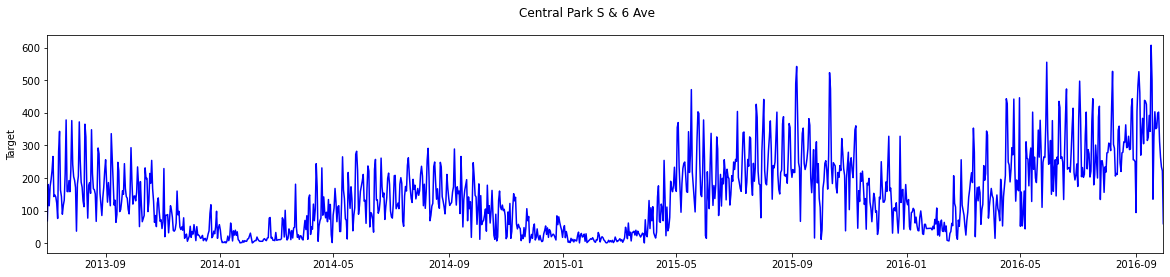

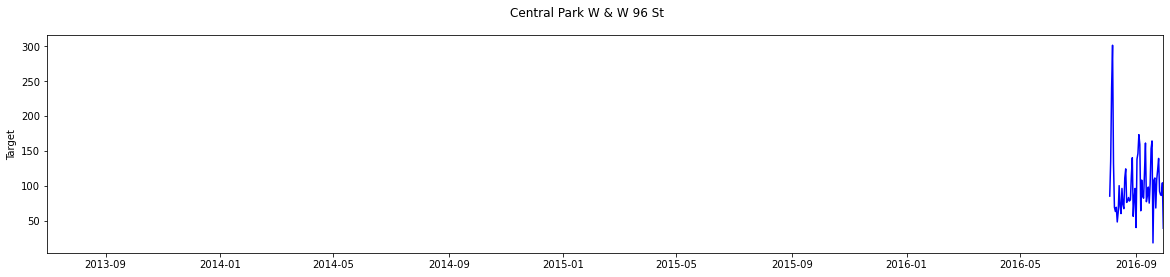

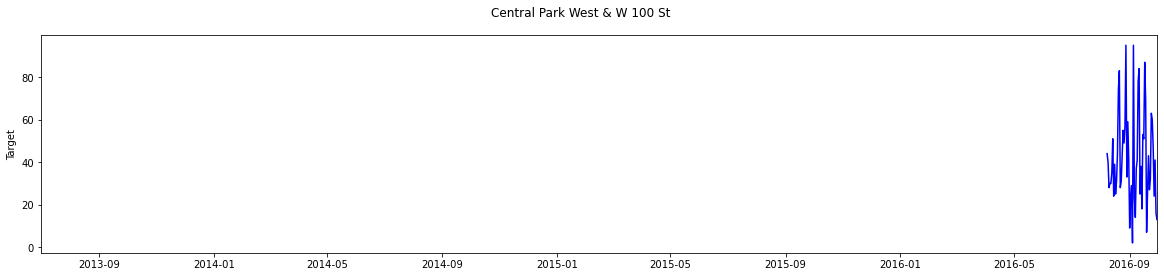

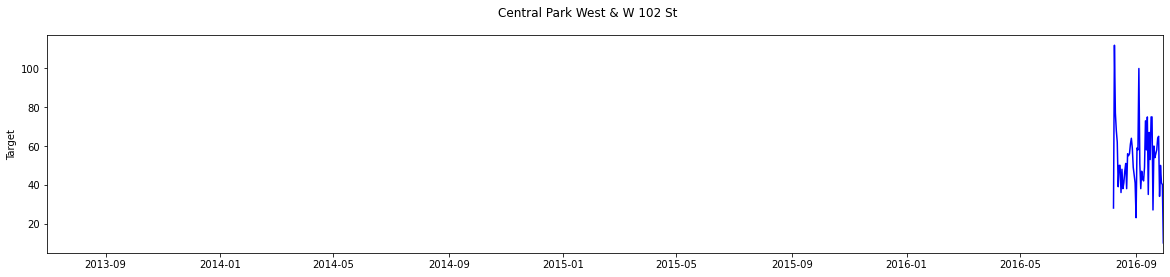

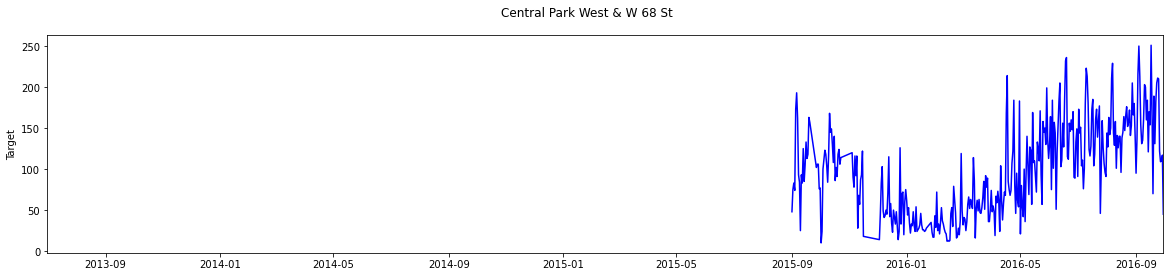

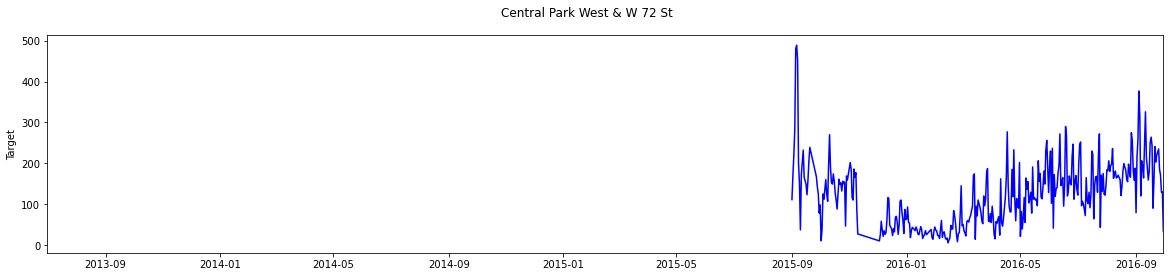

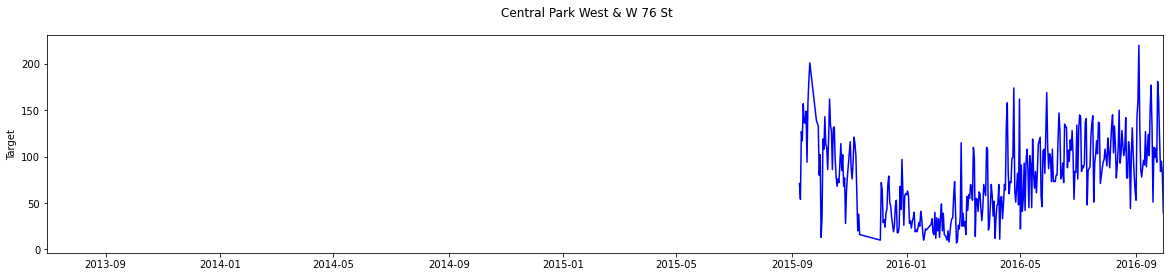

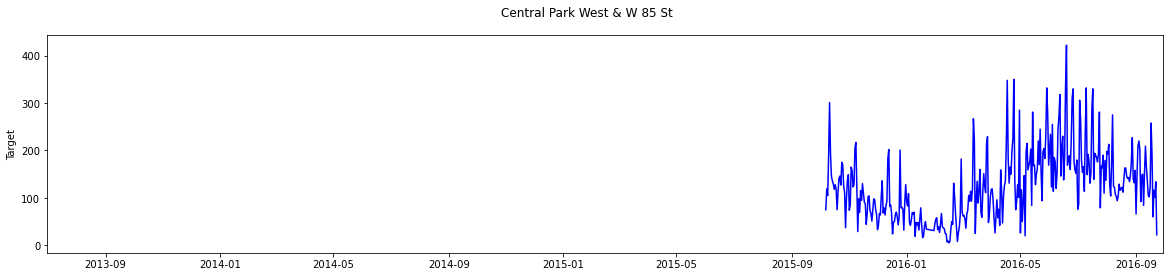

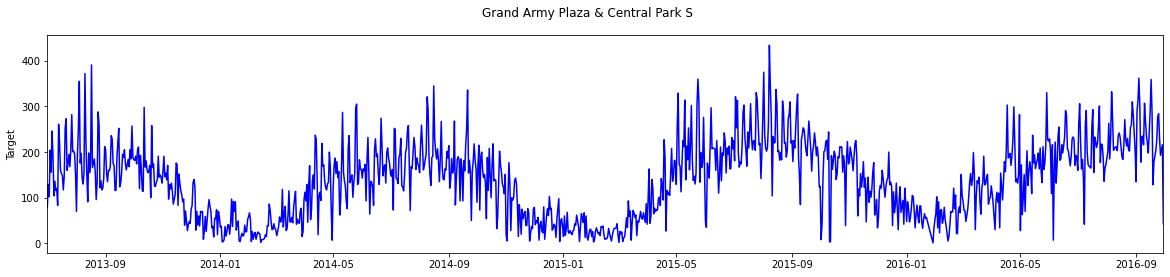

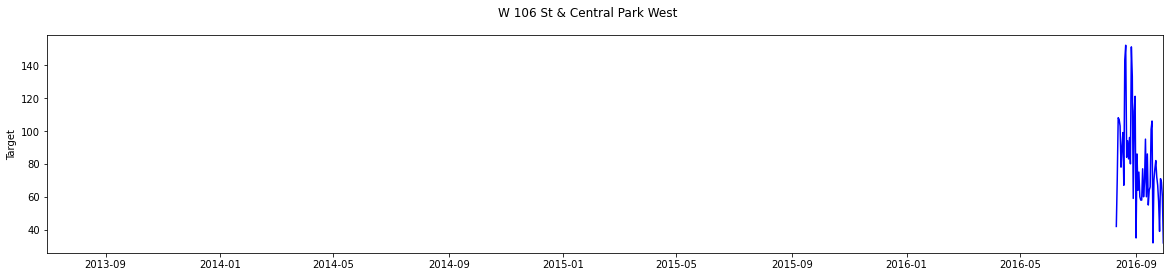

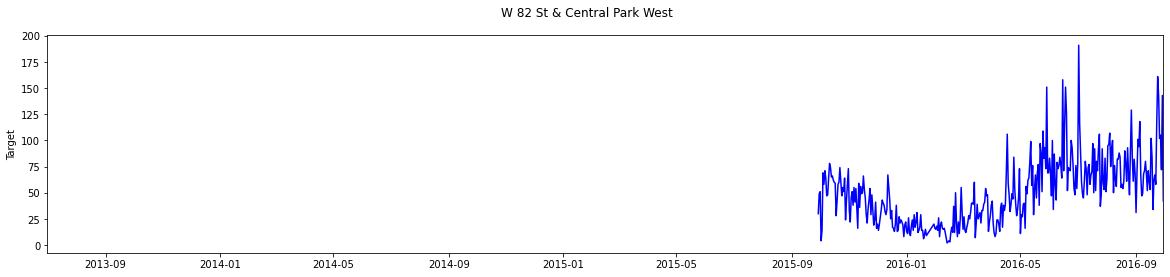

In [16]:
series = rawSeries['series'].unique().tolist()
for s, st in enumerate(series):
    # setup plot area
    plt.figure(figsize=(20, 4))
    
    # data
    plotdf = rawSeries[(rawSeries['series'] == st)]
        
    # lines and dots
    plt.plot(plotdf['date'], plotdf['target'], color = 'b', label = 'Target')
    plt.xlim(rawSeries['date'].min(), rawSeries['date'].max())
    
    # labels
    plt.ylabel('Target')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Custom Components (KFP)

Vertex AI Pipelines are made up of components that run independently with inputs and outputs that connect to form a graph - the pipeline.  For this notebook workflow the following custom components are used to orchestrate different forecasting approaches (BigQuery ML ARIMA+, Prophet, and Vertex AI AutoML Forecasting) and the different scenearios for each of these.

### Data Preparation
This component prepares the data for forecasting and adds the split column for Train/Validate/Test sets.  

In [17]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery', 'google-cloud-aiplatform']
)
def forecast_prep(
    project: str,
    region: str,
    notebook: str,
    bq_source: str,
    bq_dataset: str,
    forecast_target: str,
    forecast_date: str,
    forecast_series: str,
    forecast_granularity: str,
    forecast_test_length: int,
    forecast_val_length: int,
    forecast_horizon_length: int,
    max_context_window: int 
) -> NamedTuple('source', [('bq_input', str), ('bq_test', str), ('bq_horizon', str), ('bq_horizon_input', str), ('bq_input_query', str), ('dataset_resource_name', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_input', 'bq_test', 'bq_horizon', 'bq_horizon_input', 'bq_input_query', 'dataset_resource_name'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    bq_input = f'{project}.{bq_dataset}.forecast_input_pipeline'
    bq_test = f'{project}.{bq_dataset}.forecast_test'
    bq_horizon = f'{project}.{bq_dataset}.forecast_horizon'
    bq_horizon_input = f'{project}.{bq_dataset}.forecast_horizon_input'
    
    # Prepare forecast input
    queryTable = f"""
        CREATE OR REPLACE TABLE `{bq_input}` AS
        WITH
            FORECAST AS (
                SELECT 
                   {forecast_series} as series,
                   {forecast_date} as date,
                   {forecast_target} as target
                FROM `{bq_source}`
            )
        SELECT 
           series,
           date,
           target,
           CASE
               WHEN date > DATE_SUB((SELECT MAX(date) FROM `{bq_source}`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
               WHEN date > DATE_SUB((SELECT MAX(date) FROM `{bq_source}`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
               ELSE "TRAIN"
           END AS splits
        FROM FORECAST
        ORDER BY series, date
    """
    job = bigquery.query(query = queryTable)
    job.result()
    
    # Prepare Common Output Table for Test Data Fitted
    queryOutputTest = f"""
        CREATE OR REPLACE TABLE `{bq_test}`
        (platform STRING, method STRING, scenario STRING, series STRING, date DATE, target INT64, yhat FLOAT64, yhat_lower FLOAT64, yhat_upper FLOAT64)
    """
    job = bigquery.query(query = queryOutputTest)
    job.result()
    
    # create Vertex AI Dataset linking to bqtable
    dataset = aiplatform.TimeSeriesDataset.create(
        display_name = f'{bq_dataset}', 
        bq_source = f'bq://{bq_input}',
        labels = {'notebook':f'{notebook}'}
    )
    
    # Prepare Common Output Table For Future Data Forecasted
    queryOutputHorizon = f"""
        CREATE OR REPLACE TABLE `{bq_horizon}`
        (platform STRING, method STRING, scenario STRING, series STRING, date DATE, target INT64, yhat FLOAT64, yhat_lower FLOAT64, yhat_upper FLOAT64)
    """
    job = bigquery.query(query = queryOutputHorizon)
    job.result()
    
    # Prepare horizon table for forecasting (batch jobs for automl models) - includes max context_window (history from before the horizon)
    query = f"""
    CREATE OR REPLACE TABLE `{bq_horizon_input}` AS
    WITH
        DATELIST AS (
            SELECT *
            FROM (SELECT DISTINCT series FROM `{bq_input}`) A
            CROSS JOIN (SELECT * 
                        FROM UNNEST(GENERATE_DATE_ARRAY(
                                        DATE_SUB((SELECT MAX(date) FROM `{bq_input}`), INTERVAL {max_context_window-1} {forecast_granularity}),
                                        DATE_ADD((SELECT MAX(date) FROM `{bq_input}`), INTERVAL {forecast_horizon_length} {forecast_granularity}),
                                        INTERVAL 1 {forecast_granularity}
                                    )
                                ) AS date
                        ) B
        ),
        ADDTARGET AS (
            SELECT *
            FROM DATELIST
            LEFT OUTER JOIN (SELECT series, date, target FROM `{bq_input}`)
            USING (series, date)
            ORDER BY series, date
        ),
        LOCF AS (
            SELECT series, date,
            LAST_VALUE(target IGNORE NULLS) OVER (PARTITION BY series ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as target
            FROM ADDTARGET
        )
    SELECT series, date,
        CASE
            WHEN date > (SELECT MAX(date) FROM `{bq_input}`) THEN NULL
            ELSE target
        END AS target
    FROM LOCF
    ORDER BY series, date
    """
    job = bigquery.query(query = query)
    job.result()
    
    
    return sources(bq_input, bq_test, bq_horizon, bq_horizon_input, queryTable, dataset.resource_name)

### BigQuery ML ARIMA+
This component fits a forecasting model using BigQuery ML model type ARIMA+.  This follows the logic used in notebook `04a`.

In [18]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery']
)
def forecast_bqarima(
    project: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    forecast_test_length: int,
    forecast_horizon_length: int
) -> NamedTuple('source', [('bq_model', str), ('bq_model_query', str), ('bq_output', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_model', 'bq_model_query', 'bq_output', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameters
    table = bq_test.split('.')[-1]
    bq_model = f"{bq_test[:-(len(table)+1)]}.arimaplus"
    bq_output = f"{bq_test[:-(len(table)+1)]}.fitted_forecast_arimaplus"
    platform = 'BigQuery' 
    method = 'ARIMA_PLUS'
    scenario = 'automatic'
    
    # Create Model: ARIMA_PLUS
    # data_frequency should be ok as default = auto_frequency
    queryARIMA = f"""
        CREATE OR REPLACE MODEL `{bq_model}`
        OPTIONS
          (model_type = 'ARIMA_PLUS',
           time_series_timestamp_col = 'date',
           time_series_data_col = 'target',
           time_series_id_col = 'series',
           auto_arima_max_order = 5,
           holiday_region = 'US',
           horizon = {forecast_test_length}+{forecast_horizon_length}
          ) AS
        SELECT series, date, target
        FROM `{bq_input}`
        WHERE splits in ('TRAIN','VALIDATE')
    """
    job = bigquery.query(query = queryARIMA)
    job.result()
    
    # Create Raw Output
    query = f"""
        CREATE OR REPLACE TABLE `{bq_output}` AS
        WITH
            FORECAST AS (
                SELECT
                    series, 
                    EXTRACT(DATE from time_series_timestamp) as date,
                    time_series_adjusted_data as yhat,
                    prediction_interval_lower_bound as yhat_lower,
                    prediction_interval_upper_bound as yhat_upper
                FROM ML.EXPLAIN_FORECAST(MODEL `{bq_model}`, STRUCT({forecast_test_length+forecast_horizon_length} AS horizon, 0.95 AS confidence_level))
                WHERE time_series_type = 'forecast'
            ),
            ACTUAL AS (
                SELECT series, date, target, splits
                FROM `{bq_input}`
                WHERE splits = 'TEST'
            )
        SELECT series, date, target, yhat, yhat_lower, yhat_upper, splits
        FROM FORECAST
        LEFT OUTER JOIN ACTUAL
        USING (series, date)
        ORDER BY series, date 
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bq_test}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_test}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            series,
            date,
            target,
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits = 'TEST'
        ORDER by series, date
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Insert forecast for future horizon
    query = f"""
        DELETE `{bq_horizon}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_horizon}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            series,
            date,
            target,
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits is NULL
        ORDER by series, date
    """
    job = bigquery.query(query = query)
    job.result()
    
    return sources(bq_model, queryARIMA, bq_output, platform, method, scenario)

### Vertex AI AutoML Forecasting
This component fits a forecasting model using Vertex AI AutoML Forecasting.  This follows the logic used in notebooks `04c` and `04d`.

In [41]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['google-cloud-bigquery','google-cloud-aiplatform']
)
def forecast_automl(
    project: str,
    region: str,
    notebook: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    bq_horizon_input: str,
    dataset_rn: str, # vertex ai dataset.resource_name
    context_window: int, # context window
    forecast_granularity: str,
    forecast_granularity_count: int,
    forecast_test_length: int,
    forecast_horizon_length: int
) -> NamedTuple('source', [('bq_output', str), ('model', str), ('batch_predictions', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_output', 'model', 'batch_predictions', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    table = bq_test.split('.')[-1]
    bq_dataset = bq_test.split('.')[1]
    bq_output = f"{bq_test[:-(len(table)+1)]}.fitted_forecast_automl_{context_window}"
    platform = 'Vertex AI' 
    method = 'AutoML'
    scenario = f'cw={context_window}'
    
    # dataset
    dataset = aiplatform.TimeSeriesDataset(dataset_rn)
    
    # Delete output table from BigQuery (in case previously run created it) because AutoML will not overwrite
    query = f"""
        DROP TABLE IF EXISTS `{bq_output}`
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Create Job
    column_specs = list(set(dataset.column_names) - set(['splits','series']))
    column_specs = dict.fromkeys(column_specs, 'auto')
    column_specs
    
    forecast_job = aiplatform.AutoMLForecastingTrainingJob(
        display_name = f'{bq_dataset}_automl_{context_window}',
        optimization_objective = "minimize-rmse",
        column_specs = column_specs,
        labels = {'notebook':f'{notebook}', 'cw': f'{context_window}'}
    )
    
    # Run Job
    forecast = forecast_job.run(
        dataset = dataset,
        target_column = "target",
        time_column = "date",
        time_series_identifier_column = "series",
        unavailable_at_forecast_columns = ["target",],
        available_at_forecast_columns = ["date",],
        forecast_horizon = forecast_test_length,
        data_granularity_unit = forecast_granularity,
        data_granularity_count = forecast_granularity_count,
        predefined_split_column_name = "splits",
        context_window = context_window,
        export_evaluated_data_items = True,
        export_evaluated_data_items_bigquery_destination_uri = f"bq://{bq_output.replace('.',':')}",
        validation_options = "fail-pipeline",
        budget_milli_node_hours = 1000,
        model_display_name = f"{bq_dataset}_automl_{context_window}",
        model_labels = {'notebook':f'{notebook}', 'cw': f'{context_window}'}
    )
        
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bq_test}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    query = f"""
        INSERT INTO `{bq_test}`
        WITH
            FORECASTS AS (
                SELECT
                    DATE(date) as date,
                    DATE(predicted_on_date) as predicted_on_date,
                    CAST(target as INT64) AS target, splits,
                    series,
                    predicted_target.value as predicted_target
                FROM `{bq_output}`
            ),
            LEAD_DAYS AS (
                SELECT *, DATE_DIFF(date, predicted_on_date, {forecast_granularity}) as prediction_lead_days
                FROM FORECASTS
            ),
            LATEST AS (
                SELECT series, date, min(prediction_lead_days) as prediction_lead_days
                FROM LEAD_DAYS
                GROUP BY series, date
            ),
            DIFFS AS (
                SELECT 
                    series, date,
                    predicted_target as forecast_value,
                    target
                FROM LATEST
                LEFT OUTER JOIN LEAD_DAYS
                USING (series, date, prediction_lead_days)    
            )
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            series,
            date,
            target,
            forecast_value as yhat,
            NULL as yhat_lower,
            NULL as yhat_upper
        FROM DIFFS
        ORDER by series, date
    """
    job = bigquery.query(query = query)
    job.result()
    
    # create batch prediction job for the horizon
    batchjob = aiplatform.BatchPredictionJob.create(
        job_display_name = f'{bq_dataset}_automl_{context_window}',
        model_name = forecast.resource_name,
        instances_format = 'bigquery',
        predictions_format = 'bigquery',
        bigquery_source = f"bq://{bq_horizon_input}",
        bigquery_destination_prefix = f"bq://{project}.{bq_dataset}"
    )

    # Insert forecast for future horizon
    query = f"""
        DELETE `{bq_horizon}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    query = f"""
            INSERT INTO `{bq_horizon}`
            SELECT
                '{platform}' as platform,
                '{method}' as method,
                '{scenario}' as scenario,
                series,
                DATE(date) as date,
                NULL as target,
                predicted_target.value as yhat,
                NULL as yhat_lower,
                NULL as yhat_upper
            FROM `{project}.{bq_dataset}.{batchjob.output_info.bigquery_output_table}`
            ORDER by series, date
    """
    job = bigquery.query(query = query)
    job.result()    
    
    return sources(bq_output, forecast.resource_name, batchjob.output_info.bigquery_output_table, platform, method, scenario)

### Vertex AI Training Custom Jobs for Forecasting with Prophet
This component fits a forecasting model using a Prophet script in a custom container (built in `04f`) to fit forecasting.  This follows the logic used in notebook `04f`.

In [20]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['google-cloud-bigquery','google-cloud-aiplatform']
)
def forecast_prophet(
    project: str,
    region: str,
    notebook: str,
    bq_input: str,
    bq_test: str,
    bq_horizon: str,
    service_account: str,
    image_uri: str,
    yearly: str, # flag for prophet to add seasonality for yearly
    forecast_test_length: int,
    forecast_horizon_length: int, # forecast horizon
) -> NamedTuple('source', [('bq_output', str), ('model', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bq_output', 'model', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    platform = 'Vertex AI' 
    method = 'Prophet Container'
    if yearly == 'true': scenario = '--yearly'
    else: scenario = '--no-yearly'
    
    table = bq_test.split('.')[-1]
    bq_dataset = bq_test.split('.')[1]
    bq_output = f"{bq_test[:-(len(table)+1)]}.fitted_forecast_prophet_{scenario}"
    URI = f"gs://{project}/{bq_dataset}/models/{notebook}"
    
    # create job
    CMDARGS = [
        "--project=" + project,
        "--bq_input=" + bq_input,
        "--bq_output=" + bq_output,
        "--horizon=" + f'{forecast_horizon_length+forecast_test_length}',
        f"{scenario}"
    ]

    MACHINE_SPEC = {
        "machine_type": 'n1-standard-8',
        "accelerator_count": 0
    }

    WORKER_POOL_SPEC = [
        {
            "replica_count": 1,
            "machine_spec": MACHINE_SPEC,
            "container_spec": {
                "image_uri": image_uri,
                "command": [],
                "args": CMDARGS
            }
        }
    ]
    
    customJob = aiplatform.CustomJob(
        display_name = f'{bq_dataset}_prophet_{scenario}',
        worker_pool_specs = WORKER_POOL_SPEC,
        base_output_dir = f"{URI}/{scenario}",
        staging_bucket = f"{URI}/{scenario}",
        labels = {'notebook':f'{notebook}', 'yearly':f'{scenario}'}
    )
    
    # run job
    customJob.run(
        service_account = service_account
    )
                           
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bq_test}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_test}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            series,
            date,
            target,
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits = 'TEST'
        ORDER by series, date
    """
    job = bigquery.query(query = query)
    job.result()

    # Insert forecast for future horizon
    query = f"""
        DELETE `{bq_horizon}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bq_horizon}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            series,
            date,
            target,
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bq_output}`
        WHERE splits is NULL
        ORDER by series, date
    """
    job = bigquery.query(query = query)
    job.result()    
    
    return sources(f'{bq_output}', customJob.resource_name, platform, method, scenario)

### Custom Container Build

##### Assemble Python File For Training

In [21]:
!mkdir -p {DIR}/model/fit

In [22]:
%%writefile  {DIR}/model/fit/prophet.py
from prophet import Prophet
from google.cloud import bigquery
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import argparse

# import parameters
parser = argparse.ArgumentParser()
parser.add_argument('--project', dest = 'project', type = str)
parser.add_argument('--bq_input', dest = 'bq_input', type = str)
parser.add_argument('--bq_output', dest = 'bq_output', type = str)
parser.add_argument('--horizon', type=int)

parser.add_argument('--yearly', action='store_true')
parser.add_argument('--no-yearly', action='store_false')
parser.set_defaults(yearly=False)

args = parser.parse_args()
project = args.project
bq_input = args.bq_input
bq_output = args.bq_output

# client for BQ
bigquery = bigquery.Client(project = project)

# input data - from BQ
query = f"SELECT * FROM `{bq_input}` ORDER by series, date"
source = bigquery.query(query = query).to_dataframe()

# preprocess data - as a list of dataframes for each series
seriesNames = source['series'].unique().tolist()
seriesFrames = []
for s in seriesNames:
    frame = source[(source['series']==s) & (source['splits']!='TEST')][['date','target']].rename(columns={'date':'ds','target':'y'})
    seriesFrames.append(frame)

# function to run a prophet fit & forecast
def run_prophet(series):
    if args.yearly:
        p = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    else:
        p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = args.horizon, include_history = False)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

# run the series in a thread pool for multiprocessing
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

# postprocess data - add series name back to dataframe and concatenate all into one dataframe
for i, p in enumerate(predictions):
    p['series'] = seriesNames[i]
output = pd.concat(predictions)

# output data - to BQ
output.to_gbq(f"{bq_output}", f"{bq_input.split('.')[0]}", if_exists = 'replace')

# Transform final data in BQ - merge with original input
query = f"""
CREATE OR REPLACE TABLE `{bq_output}` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{bq_input}`
        WHERE splits='TEST'
    ),
    PROPHET AS (
        SELECT series, DATE(ds) as date, yhat, yhat_lower, yhat_upper
        FROM `{bq_output}`
    )
SELECT *
FROM PROPHET
LEFT OUTER JOIN SOURCE
USING (series, date)
ORDER by series, date
"""
Tjob = bigquery.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

Writing temp/04g/model/fit/prophet.py


##### Choose a Base Image

In [23]:
BASE_IMAGE # Defined above in Setup

'gcr.io/deeplearning-platform-release/base-cpu'

##### Create the Dockerfile
A basic dockerfile thats take the base image and copies the code in and define an entrypoint - what python script to run first in this case.  Add RUN entries to pip install additional packages.

In [24]:
dockerfile = f"""
FROM {BASE_IMAGE}
WORKDIR /
RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
## Copies the trainer code to the docker image
COPY fit /fit
## Sets up the entry point to invoke the trainer
ENTRYPOINT ["python", "-m", "fit.prophet"]
"""
with open(f'{DIR}/model/Dockerfile', 'w') as f:
    f.write(dockerfile)

##### Enable Artifact Registry API:
Check to see if the api is enabled, if not then enable it:

In [25]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: statmike-demo3


##### Create A Repository
Check to see if the registry is already created, if not then create it

In [26]:
repositories = !gcloud artifacts repositories list --format="json" --filter=REPOSITORY:{PROJECT_ID}
repositories = json.loads("".join(repositories[2:]))

if len(repositories) > 0:
    print(f'There is already a repository named {PROJECT_ID}')
else:
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"

There is already a repository named statmike-demo3


##### Configure Local Docker to Use GCLOUD CLI

In [27]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


##### Build The Custom Container (local to notebook)

In [28]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g:latest'

In [29]:
!docker build {DIR}/model/. -t $IMAGE_URI

Sending build context to Docker daemon  6.144kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/base-cpu
 ---> 0db22ebb67a2
Step 2/5 : WORKDIR /
 ---> Using cache
 ---> 0cd00ac54c94
Step 3/5 : RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
 ---> Using cache
 ---> 9b2cb187c18b
Step 4/5 : COPY fit /fit
 ---> Using cache
 ---> 925ad647a854
Step 5/5 : ENTRYPOINT ["python", "-m", "fit.prophet"]
 ---> Using cache
 ---> 419e5afca3cd
Successfully built 419e5afca3cd
Successfully tagged us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g:latest


##### Push The Container to The Repository

In [30]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g]

c4c65c12: Preparing 
cfecee76: Preparing 
dd2b9e38: Preparing 
e29d8d24: Preparing 
95a574c8: Preparing 
10151b48: Preparing 
c089358e: Preparing 
9b36546a: Preparing 
82ce8d0b: Preparing 
467ac3a5: Preparing 
91c31559: Preparing 
ae11254c: Preparing 
2bcbe281: Preparing 
4c112e39: Preparing 
048fd290: Preparing 
bf18a086: Preparing 
7a45d8d8: Preparing 
6651fb01: Preparing 
d5cafaa0: Preparing 
5fa9d77e: Layer already exists latest: digest: sha256:2d0910544dba700277c7df068dc0b9c71295641bf21dec7370da9a9ad72009e4 size: 4501


### Custom Metrics
This component calculates custom metrics for all time series and all methods to select the best method per series and prepare a champion prediction file in BigQuery.

In [31]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery']
)
def forecast_metrics(
    project: str,
    bq_test: str,
    platform: str,
    method: str,
    scenario: str,
    metrics: dsl.Output[dsl.Metrics]
) -> NamedTuple('metrics', [('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('metrics', ['MAPE', 'MAE', 'pMAE'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
        
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    target,
                    series, 
                    yhat,
                    (target - yhat) as diff
                FROM `{bq_test}`
                WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
            )
        SELECT
            AVG(ABS(diff)/target) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(target) as pMAE
        FROM FORECASTS
    """
    customMetrics = bigquery.query(query = query).to_dataframe()
    metrics.log_metric('MAPE', customMetrics['MAPE'][0])
    metrics.log_metric('MAE', customMetrics['MAE'][0])
    metrics.log_metric('pMAE', customMetrics['pMAE'][0])
    
    return sources(customMetrics['MAPE'][0], customMetrics['MAE'][0], customMetrics['pMAE'][0])

### Champion Selection: Overall

In [32]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery']
)
def forecast_champion_method(
    project: str,
    bq_test: str,
    bq_horizon: str,
    metrics: dsl.Output[dsl.Metrics]
) -> NamedTuple('metrics', [('bq_champion_test', str), ('bq_champion_horizon', str), ('platform', str), ('method', str), ('scenario', str), ('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('metrics', ['bq_champion_test', 'bq_champion_horizon', 'platform', 'method','scenario', 'MAPE', 'MAE', 'pMAE'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameter
    table = bq_test.split('.')[-1]
    bq_champion_test = f"{bq_test[:-(len(table)+1)]}.champion_overall_test"
    bq_champion_horizon = f"{bq_test[:-(len(table)+1)]}.champion_overall_horizon"
    
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    target,
                    series, 
                    yhat,
                    (target - yhat) as diff
                FROM `{bq_test}`
            )
        SELECT
            platform, method, scenario,
            AVG(ABS(diff)/target) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(target) as pMAE
        FROM FORECASTS
        GROUP BY platform, method, scenario
    """
    customMetrics = bigquery.query(query = query).to_dataframe()

    # pick champion
    # must be best (MAE and pMAE), else best (MAPE and pMAE), else best pMAE
    customMetrics['MAE_RANK'] = customMetrics['MAE'].rank(method='min')
    customMetrics['pMAE_RANK'] = customMetrics['pMAE'].rank(method='min')
    customMetrics['MAPE_RANK'] = customMetrics['MAPE'].rank(method='min')

    customMetrics['champion'] = 0
    customMetrics.loc[(customMetrics['MAE_RANK'] == 1) & (customMetrics['pMAE_RANK'] == 1), 'champion'] = 1

    if customMetrics['champion'].sum() != 1:
        customMetrics['champion'] = 0
        customMetrics.loc[(customMetrics['MAPE_RANK'] == 1) & (customMetrics['pMAE_RANK'] == 1), 'champion'] = 1

    if customMetrics['champion'].sum() != 1:
        customMetrics['champion'] = 0
        customMetrics.loc[customMetrics['pMAE_RANK'] == 1, 'champion'] = 1

    keepindex = customMetrics['champion'].eq(1).idxmax()

    # create champion_method tables in same dataset
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_test}` AS
        SELECT *
        FROM `{bq_test}`
        WHERE
            platform = '{customMetrics['platform'][keepindex]}' AND
            method = '{customMetrics['method'][keepindex]}' AND
            scenario = '{customMetrics['scenario'][keepindex]}'
        ORDER BY series, date
    """
    job = bigquery.query(query = query)
    job.result()
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_horizon}` AS
        SELECT *
        FROM `{bq_horizon}`
        WHERE
            platform = '{customMetrics['platform'][keepindex]}' AND
            method = '{customMetrics['method'][keepindex]}' AND
            scenario = '{customMetrics['scenario'][keepindex]}'
        ORDER BY series, date
    """
    job = bigquery.query(query = query)
    job.result()
    
    
    # log metric artifacts
    metrics.log_metric('MAPE', customMetrics['MAPE'][keepindex])
    metrics.log_metric('MAE', customMetrics['MAE'][keepindex])
    metrics.log_metric('pMAE', customMetrics['pMAE'][keepindex])
    metrics.log_metric('methods', customMetrics.shape[0])
    metrics.log_metric('MAPE_RANK', customMetrics['MAPE_RANK'][keepindex])
    metrics.log_metric('MAE_RANK', customMetrics['MAE_RANK'][keepindex])
    metrics.log_metric('pMAE_RANK', customMetrics['pMAE_RANK'][keepindex])
    
    return sources(bq_champion_test, bq_champion_horizon, customMetrics['platform'][keepindex] , customMetrics['method'][keepindex], customMetrics['scenario'][keepindex], customMetrics['MAPE'][keepindex], customMetrics['MAE'][keepindex], customMetrics['pMAE'][keepindex])

### Champion Selection: By Series

In [33]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','db-dtypes','google-cloud-bigquery', 'pretty_html_table']
)
def forecast_champion_method_series(
    project: str,
    bq_test: str,
    bq_horizon: str,
    metrics: dsl.Output[dsl.HTML]
) -> NamedTuple('sources', [('bq_champion_test', str), ('bq_champion_horizon', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('sources', ['bq_champion_test', 'bq_champion_horizon'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from pretty_html_table import build_table
    
    # parameter
    table = bq_test.split('.')[-1]
    bq_champion_test = f"{bq_test[:-(len(table)+1)]}.champion_series_test"
    bq_champion_horizon = f"{bq_test[:-(len(table)+1)]}.champion_series_horizon"
    
    # metrics
    metricQuery = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    target,
                    series, 
                    yhat,
                    (target - yhat) as diff
                FROM `{bq_test}`
            ),
            METRICS AS (
                SELECT
                    series, platform, method, scenario,
                    AVG(ABS(diff)/target) as MAPE,
                    AVG(ABS(diff)) as MAE,
                    SUM(ABS(diff))/SUM(target) as pMAE
                FROM FORECASTS
                GROUP BY series, platform, method, scenario
            ),
            RANKS AS (
                SELECT *,
                    RANK() OVER (PARTITION BY series ORDER BY MAPE) as MAPE_RANK,
                    RANK() OVER (PARTITION BY series ORDER BY MAE) as MAE_RANK,
                    RANK() OVER (PARTITION BY series ORDER BY pMAE) as pMAE_RANK
                FROM METRICS
            ),
            CRITERIA AS (
                SELECT *,
                    CASE WHEN (MAE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_1,
                    CASE WHEN (MAPE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_2,
                    CASE WHEN (pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_3
                FROM RANKS        
            ),
            RULES AS (
                SELECT
                    series,
                    CASE
                        WHEN SUM(CHAMPION_1) = 1 THEN 1
                        WHEN SUM(CHAMPION_2) = 1 THEN 2
                        ELSE 3
                    END AS CHAMPION
                FROM CRITERIA
                GROUP BY series
            ),
            CHAMPION AS (
                SELECT A.* EXCEPT(CHAMPION_1, CHAMPION_2, CHAMPION_3)
                FROM CRITERIA A
                JOIN RULES B
                ON A.series = B.series
                    AND ((A.CHAMPION_1 = 1 and B.CHAMPION = 1) OR (A.CHAMPION_2 = 1 and B.CHAMPION = 2) OR (A.CHAMPION_3 = 1 and B.CHAMPION = 3))
            )
    """
    
    query = f"""
{metricQuery}
        SELECT *
        FROM CHAMPION
        ORDER BY series
    """
    customMetrics = bigquery.query(query = query).to_dataframe() 

    # create champion_series tables in same dataset - an extension of the metric SQL above to creates the table
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_test}` AS
{metricQuery}
            SELECT *
            FROM (SELECT series, platform, method, scenario FROM CHAMPION) A
            LEFT OUTER JOIN (SELECT * FROM `{bq_test}`) B
            USING (series, platform, method, scenario)
            ORDER BY series, date
    """
    job = bigquery.query(query = query)
    job.result()

    # create champion_series tables in same dataset - an extension of the metric SQL above to creates the table
    query = f"""
        CREATE OR REPLACE TABLE `{bq_champion_horizon}` AS
{metricQuery}
            SELECT *
            FROM (SELECT series, platform, method, scenario FROM CHAMPION) A
            LEFT OUTER JOIN (SELECT * FROM `{bq_horizon}`) B
            USING (series, platform, method, scenario)
            ORDER BY series, date
    """
    job = bigquery.query(query = query)
    job.result()    

    # log metric artifacts as html
    with open(metrics.path, 'w') as f:
        #f.write(customMetrics.to_html(index = False))
        f.write(build_table(customMetrics, 'blue_light'))
        
    return sources(bq_champion_test, bq_champion_horizon)

---
## Vertex AI Pipeline

### Pipeline (KFP) Definition

In [42]:
@dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-tournament',
    pipeline_root = URI + '/kfp/'
)
def pipeline(
    project: str,
    region: str,
    notebook: str,
    bq_source: str,
    bq_dataset: str,
    service_account: str,
    image_uri: str,
    forecast_target: str,
    forecast_date: str,
    forecast_series: str,
    forecast_granularity: str,
    forecast_granularity_count: int,
    forecast_test_length: int,
    forecast_val_length: int,
    forecast_horizon_length: int,
    cwValues: list,
    max_context_window: int
):
    
    source = forecast_prep(
        project = project,
        region = region,
        notebook = notebook,
        bq_source = bq_source,
        bq_dataset = bq_dataset,
        forecast_target = forecast_target,
        forecast_date = forecast_date,
        forecast_series = forecast_series,
        forecast_granularity = forecast_granularity,
        forecast_test_length = forecast_test_length,
        forecast_val_length = forecast_val_length,
        forecast_horizon_length = forecast_horizon_length,
        max_context_window = max_context_window
    )
    source.set_caching_options(True)
    
    arima = forecast_bqarima(
        project = project,
        bq_input = source.outputs['bq_input'],
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon'],
        forecast_test_length = forecast_test_length,
        forecast_horizon_length = forecast_horizon_length
    )
    arima.set_caching_options(True)

    arima_metrics = forecast_metrics(
        project = project,
        bq_test = source.outputs['bq_test'],
        platform = arima.outputs['platform'],
        method = arima.outputs['method'],
        scenario = arima.outputs['scenario']
    )
    arima_metrics.set_caching_options(True)

    with dsl.ParallelFor(cwValues) as cw:
    
        automl = forecast_automl(
            project = project,
            region = region,
            notebook = notebook,
            bq_input = source.outputs['bq_input'],
            bq_test = source.outputs['bq_test'],
            bq_horizon = source.outputs['bq_horizon'],
            bq_horizon_input = source.outputs['bq_horizon_input'],
            dataset_rn = source.outputs['dataset_resource_name'], # vertex ai dataset.resource_name
            context_window = cw, # context window
            forecast_granularity = forecast_granularity,
            forecast_granularity_count = forecast_granularity_count,
            forecast_test_length = forecast_test_length,
            forecast_horizon_length = forecast_horizon_length
        )
        automl.set_caching_options(True)
        
        automl_metrics = forecast_metrics(
            project = project,
            bq_test = source.outputs['bq_test'],
            platform = automl.outputs['platform'],
            method = automl.outputs['method'],
            scenario = automl.outputs['scenario']
        )
        automl_metrics.set_caching_options(True)
        
    yearvals = ['true', 'false']
    with dsl.ParallelFor(yearvals) as yv:
        
        prophet = forecast_prophet(
            project = project,
            region = region,
            notebook = notebook,
            bq_input = source.outputs['bq_input'],
            bq_test = source.outputs['bq_test'],
            bq_horizon = source.outputs['bq_horizon'],
            service_account = service_account,
            image_uri = image_uri,
            yearly = yv, # flag for prophet to add seasonality for yearly
            forecast_test_length = forecast_test_length,
            forecast_horizon_length = forecast_horizon_length
        )
        prophet.set_caching_options(True)
        
        prophet_metrics = forecast_metrics(
            project = project,
            bq_test = source.outputs['bq_test'],
            platform = prophet.outputs['platform'],
            method = prophet.outputs['method'],
            scenario = prophet.outputs['scenario']
        )
        prophet_metrics.set_caching_options(True)
        
    methodChampion = forecast_champion_method(
        project = project,
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon']
    )
    methodChampion.set_caching_options(False)
    methodChampion.after(arima_metrics, automl_metrics, prophet_metrics)

    seriesChampion = forecast_champion_method_series(
        project = project,
        bq_test = source.outputs['bq_test'],
        bq_horizon = source.outputs['bq_horizon']  
    )
    seriesChampion.set_caching_options(False)
    seriesChampion.after(arima_metrics, automl_metrics, prophet_metrics)
        

### Compile Pipeline

In [43]:
kfp.v2.compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

### Create Vertex AI Pipeline Job

In [44]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"{NOTEBOOK}_tournament",
    template_path = f"{DIR}/{NOTEBOOK}.json",
    parameter_values = {
        "project" : f'{PROJECT_ID}',
        "region" : f'{REGION}',
        "notebook" : f'{NOTEBOOK}',
        "bq_source" : f'{PROJECT_ID}.{BQ_DATASET}.forecast_input',
        "bq_dataset" : f'{BQ_DATASET}',
        "service_account" : f'{SERVICE_ACCOUNT}',
        "image_uri" : f'{IMAGE_URI}',
        "forecast_target" : 'target',
        "forecast_series" : 'series',
        "forecast_date" : "date",
        "forecast_granularity" : "day", # minute, hour, day ,week month, year
        "forecast_granularity_count" : 1, # 1, unless minute and then 1, 5, 10, 15, 30
        "forecast_test_length" : 14,
        "forecast_val_length" : 14,
        "forecast_horizon_length" : 14,
        "cwValues" : [28, 14, 7, 4, 2, 1, 0], # don't exceed qouta for concurrent AutoML Jobs
        "max_context_window": 28
    },
    enable_caching = None,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [45]:
response = pipeline_job.run(
    service_account = SERVICE_ACCOUNT,
    sync = False
)

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220412100013
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220412100013')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-04g-tournament-20220412100013?project=715288179162
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220412100013 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/715288179162/locations/us-central1/pipeli

### Review Pipeline Job

<img src="architectures/notebooks/04g_screenshots/pipeline.png">

<img src="architectures/notebooks/04g_screenshots/results.png">

## Results

### Retrieve Source Data

In [54]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.04g_tournament.forecast_input`
"""
rawSeries = bigquery.query(query = query).to_dataframe()
rawSeries.head()

,series,date,target,splits
0,Central Park North & Adam Clayton Powell Blvd,2016-09-01,14,TRAIN
1,Central Park North & Adam Clayton Powell Blvd,2016-09-02,151,TRAIN
2,Central Park North & Adam Clayton Powell Blvd,2016-09-03,255,VALIDATE
3,Central Park North & Adam Clayton Powell Blvd,2016-09-04,328,VALIDATE
4,Central Park North & Adam Clayton Powell Blvd,2016-09-05,259,VALIDATE


### Retrieve Fit Data

In [55]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.04g_tournament.champion_series_test`
"""
fitSeries = bigquery.query(query = query).to_dataframe()
fitSeries.head()

,series,platform,method,scenario,date,target,yhat,yhat_lower,yhat_upper
0,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-09-17,269,222.073810,172.561627,271.585993
1,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-09-18,272,272.027386,218.500039,325.554734
2,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-09-19,39,179.141387,125.923309,232.359466
3,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-09-20,120,122.190145,65.880721,178.499569
4,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-09-21,164,121.622393,52.250708,190.994077


### Retrieve Horizon Data

In [56]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.04g_tournament.champion_series_horizon`
ORDER BY series, date
"""
horizon = bigquery.query(query = query).to_dataframe()
horizon.head()

,series,platform,method,scenario,date,target,yhat,yhat_lower,yhat_upper
0,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-10-01,NaN,213.374917,144.003232,282.746601
1,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-10-02,NaN,261.531850,192.160165,330.903534
2,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-10-03,NaN,188.854217,119.482533,258.225902
3,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-10-04,NaN,128.444923,59.073239,197.816608
4,Central Park North & Adam Clayton Powell Blvd,BigQuery,ARIMA_PLUS,automatic,2016-10-05,NaN,122.336089,52.964404,191.707773


### Retrieve Key Dates

In [ ]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.04g_tournament.forecast_input`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, {granularity})+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

### Visualize The Time Series With Forecast (Test Period)

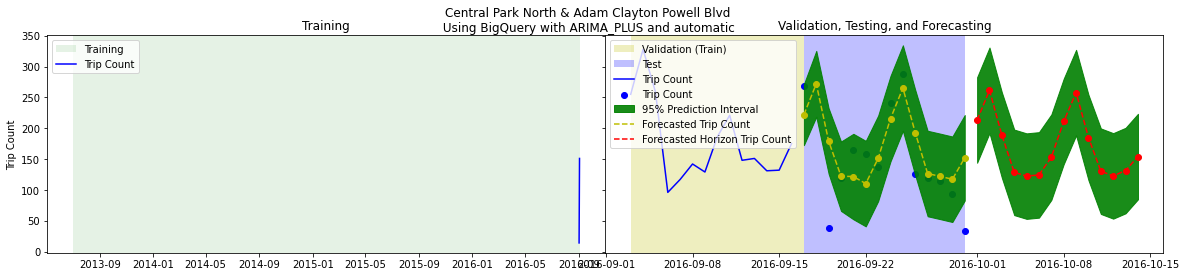

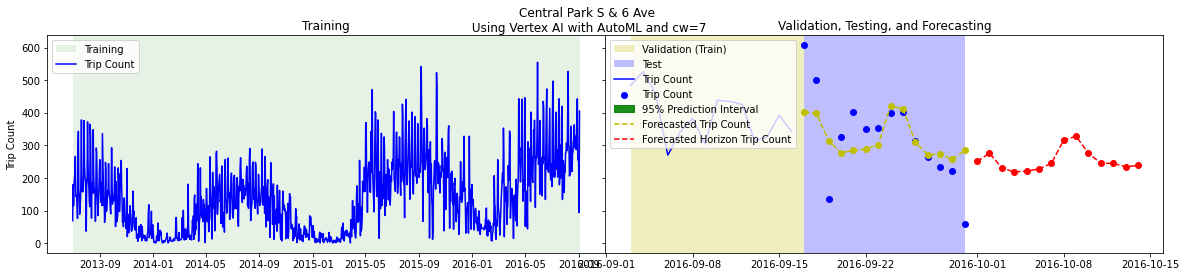

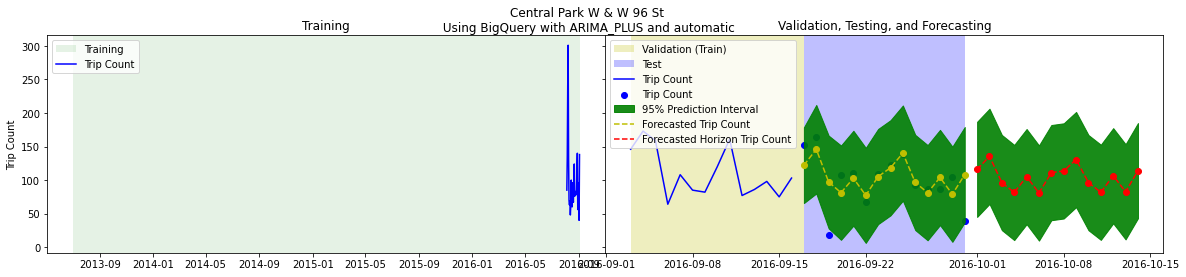

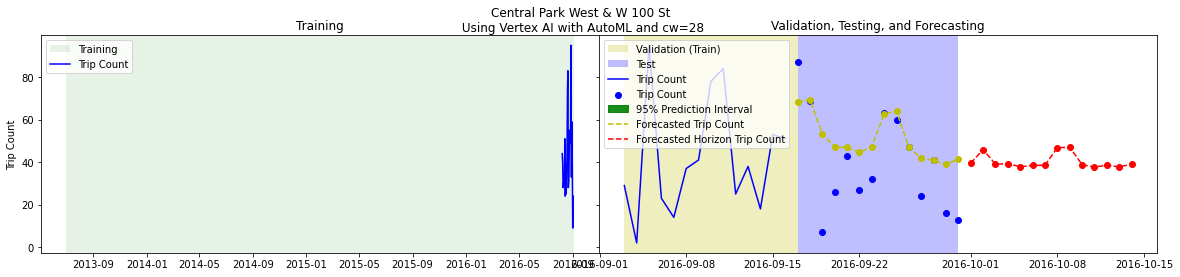

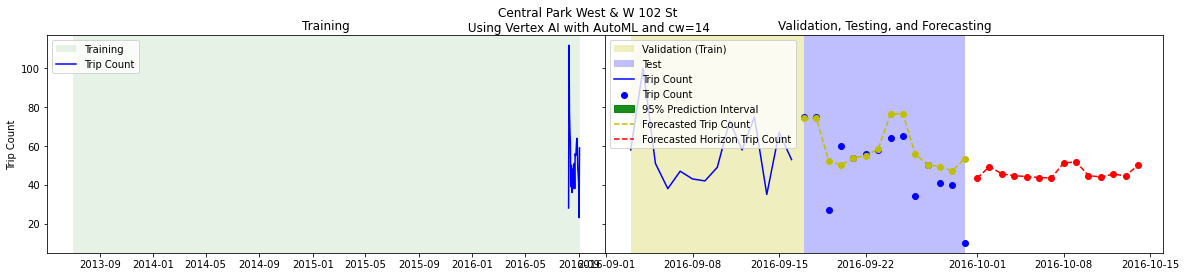

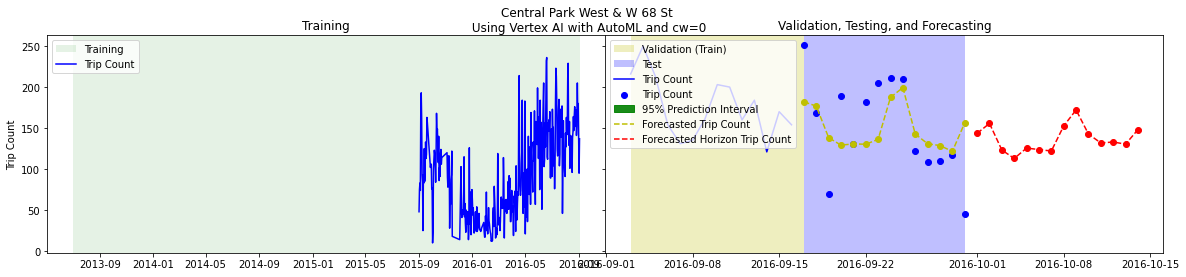

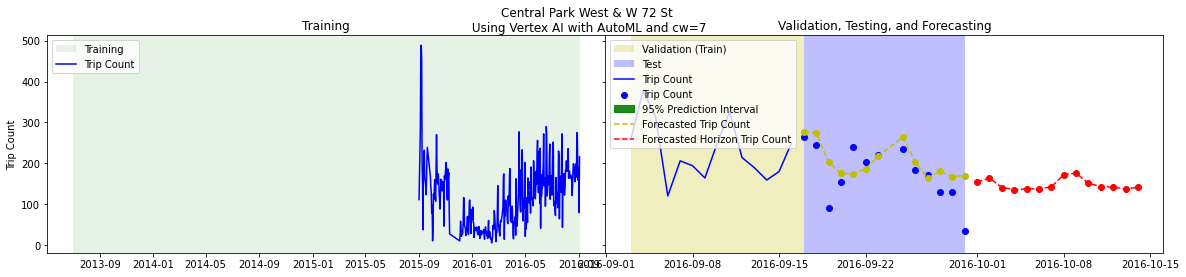

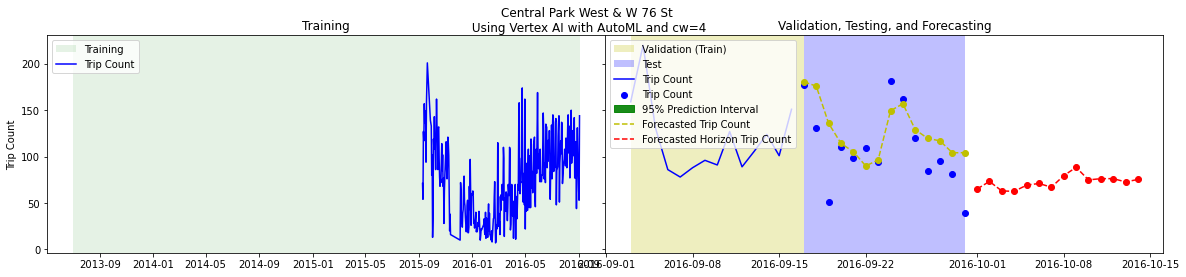

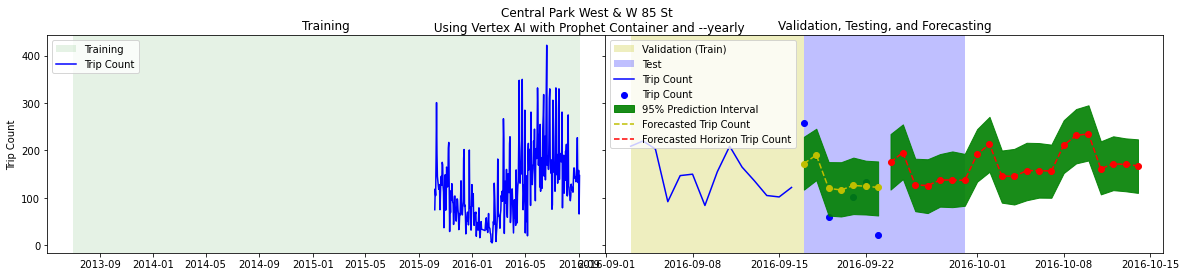

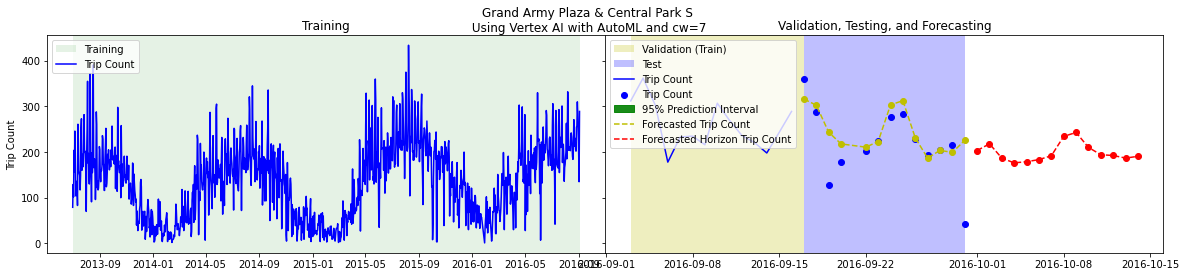

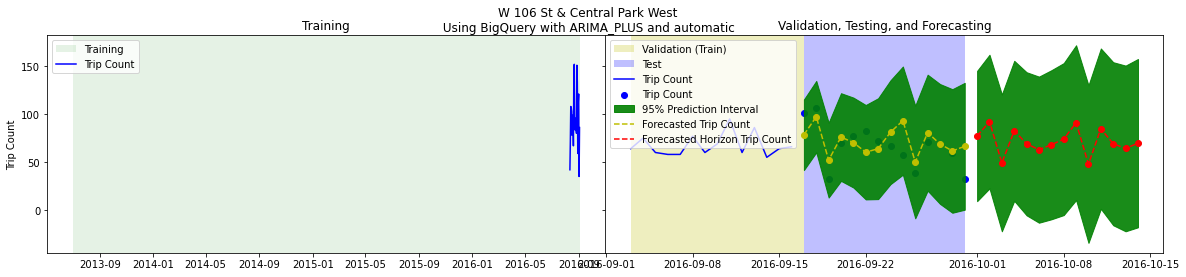

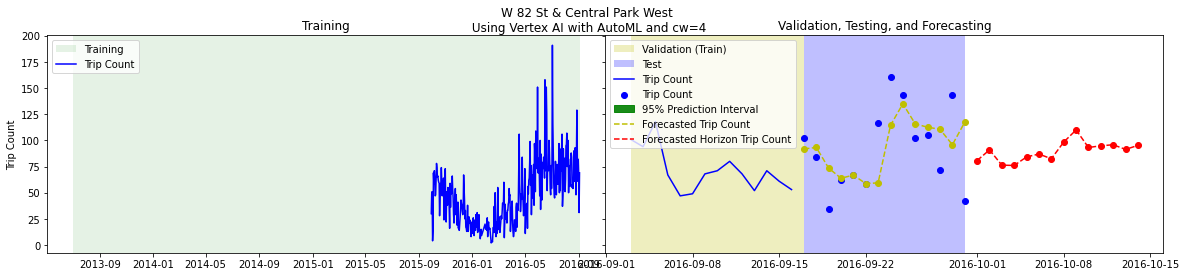

In [58]:
target_label = 'Trip Count'
series = rawSeries['series'].unique().tolist()
for s, st in enumerate(series):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['series'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['series'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['series'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = fitSeries[(fitSeries['series'] == st)]
    horizondf = horizon[(horizon['series'] == st)]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # plot raw time series
    axes[0].plot(traindf['date'], traindf['target'], color = 'b', label = target_label)
    axes[1].plot(valdf['date'], valdf['target'], color = 'b', label = target_label)
    axes[1].scatter(testdf['date'], testdf['target'], color = 'b', label = target_label)
    
    # plot fitted test data
    axes[1].fill_between(fit_testdf['date'], fit_testdf['yhat_lower'], fit_testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].plot(fit_testdf['date'], fit_testdf['yhat'], color = 'y', label = 'Forecasted '+target_label, linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['yhat'], color = 'y')
    
    axes[1].fill_between(horizondf['date'], horizondf['yhat_lower'], horizondf['yhat_upper'], color = 'g', alpha = 0.9)
    axes[1].plot(horizondf['date'], horizondf['yhat'], color = 'r', label = 'Forecasted Horizon '+target_label, linestyle='dashed')
    axes[1].scatter(horizondf['date'], horizondf['yhat'], color = 'r')
    
    # labels
    axes[0].set_ylabel(target_label)
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    
    # title
    platform, method, scenario = fitSeries[fitSeries['series'] == st][['platform','method','scenario']].iloc[0]
    plt.suptitle(st + f"\n Using {platform} with {method} and {scenario}")

    # display result
    plt.show()